In [ ]:
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# Etude 1 - Reber Grammar Verifier

Embedded Reber grammars were used by Hochreiter and Schmidhuber in their paper about LSTMs. They are artificial grammars that produce strings such as “BPBTSXXVPSEPE.” Check out <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html">Jenny Orr’s</a> nice introduction to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr’s page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don’t.

Let's implement the following grammar:

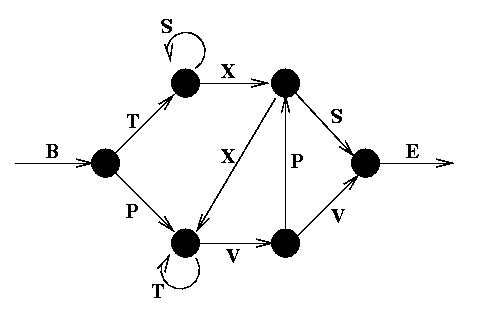

In [ ]:
def generate_grammar():
    """Randomly generates 'true' and non-Reber ('false') grammar strings
    and returns them with corresponding labels."""
    
    reber_type = random.choice([0, 1]) # 0 - "false" grammar, 1 - "true" grammar
    if reber_type == 1:
        # true rebber grammar
        
        # the transition graph where each row corresponds to the node
        # and which describes the connections of this node with other nodes
        grammar_graph = [
            [('T', 1), ('P', 2)], #0
            [('S', 1), ('X', 3)], #1 - first upper node
            [('T', 2), ('V', 4)], #2 - first lower node
            [('X', 2), ('S', 5)], #3 - second upper node
            [('P', 3), ('V', 5)], #4 - second lower node
            [('E', -1)] #5 
        ]
    
    else:
        # non-rebber grammar
        grammar_graph = [
            [('T', 1), ('P', 2)], #0
            [('S', 1), ('X', 3)], #1
            [('X', 2), ('V', 4)], #2
            [('T', 2), ('P', 5)], #3
            [('P', 3), ('S', 5)], #4
            [('E', -1)] #5 
        ]
    
    node_idx = 0
    letters = ['B']
    
    # starting from row 0 of the graph, we randomly select
    # the transition, save the letter, and then go to the row that corresponds
    # to the index specified in that transition
    while node_idx != -1:
        letter, node_idx = random.choice(grammar_graph[node_idx])
        letters.append(letter)
    return letters, reber_type

In [ ]:
letters, string_class = generate_grammar()
letters, string_class

(['B', 'P', 'X', 'V', 'P', 'P', 'E'], 0)

First let's try to create the dataset using ragged tensors.

In [ ]:
NUMBER_OF_SAMPLES = 30000

## Using TextVectorization with Ragged Tensors

In [ ]:
def generate_ragged_dataset(number_of_samples):
    """Generates the ragged tensor as strings and normal tensor as y;
    also retuns the maximum string lenght in the generated dataset
    """
    X_tensors_list = []
    y_tensors_list = []
    
    max_string_len = 0
    for sample in range(number_of_samples):
        letters, string_class = generate_grammar()
        # X_tensor = tf.ragged.constant(letters, inner_shape = (len(letters), 1), dtype='string')
        X_tensor = tf.ragged.constant(letters, inner_shape = (len(letters),), dtype='string')
        if len(letters) > max_string_len: # returns the length of the longest string
             max_string_len = len(letters)
        y_tensor = tf.constant(string_class, dtype='int64', shape=(1,))
        X_tensors_list.append(X_tensor)
        y_tensors_list.append(y_tensor)
    X_ragged = tf.ragged.stack([tensor for tensor in X_tensors_list], axis=0)
    y = tf.stack([tensor for tensor in y_tensors_list], axis=0)
    return X_ragged, y, max_string_len

In [ ]:
X, y, max_str_len = generate_ragged_dataset(NUMBER_OF_SAMPLES)

In [ ]:
print (f'X shape: {X.shape}, y shape: {y.shape}, max string length: {max_str_len}')

X shape: (30000, None), y shape: (30000, 1), max string length: 38


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [ ]:
next(iter(dataset))

(<tf.Tensor: shape=(8,), dtype=string, numpy=array([b'B', b'P', b'X', b'X', b'V', b'P', b'P', b'E'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>)

Let's convert each set of string characters to the string where space is used as a separator.

In [ ]:
dataset = dataset.map(lambda x, y: (tf.strings.reduce_join([x], separator=' '), y))

In [ ]:
next(iter(dataset))

(<tf.Tensor: shape=(), dtype=string, numpy=b'B P X X V P P E'>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>)

First let's try to use the preprocessing.TextVectorization layer introduced in TF 2.1. To do this, we first must create a dataset consisting only of strigns and of the shape (num_samples, 1, str_len). We must also specify the number of unique letters for the layer and run the adapt() method.

In [ ]:
# here we prepare the dataset for the adapt() method by adding an extra dimension
text_dataset = dataset.map(lambda x, y: tf.expand_dims(x, 0))
for item in text_dataset.take(2):
    print(item)

tf.Tensor([b'B P X X V P P E'], shape=(1,), dtype=string)
tf.Tensor([b'B T S S X X V V E'], shape=(1,), dtype=string)


Now let's run the adapt() method.

In [ ]:
NUM_LETTERS = 7 

vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
  # 7 + 1 for oov bucket, supposely (not sure)
  # if specifying 7 as max_token, for some reason
  # we get the vocabulary stripped by one symbol 'b' (i.e. of lenght 6, not 7)
  max_tokens=NUM_LETTERS + 2,
  output_mode='int',
  output_sequence_length=max_str_len)

In [ ]:
try:
    vectorize_layer.adapt(text_dataset)
except tf.errors.InvalidArgumentError as exc:
    print(exc)

In [ ]:
vectorize_layer.get_vocabulary()

['', '[UNK]', 't', 'v', 'p', 'x', 'e', 'b', 's']

In [ ]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    # without the mask_zero parameter, the training takes much longer;
    # probably, ragged tensors are masked with zeros too
    # unfortunately, the usage of the mask_zero parameter with the vectorize layer is not documented well
    keras.layers.Embedding(NUM_LETTERS + 2, 40, mask_zero=True),
    keras.layers.GRU(100),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
train_size = int(0.7 * NUMBER_OF_SAMPLES)
val_size = int(0.15 * NUMBER_OF_SAMPLES)
test_size = int(0.15 * NUMBER_OF_SAMPLES)

In [ ]:
train = dataset.take(train_size)
test = dataset.skip(train_size)
val = test.take(val_size)
test = test.skip(test_size)

In [ ]:
for item in train.take(2):
    print(item)

(<tf.Tensor: shape=(), dtype=string, numpy=b'B P X X V P P E'>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'B T S S X X V V E'>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>)


In [ ]:
train_ds = train.shuffle(100).repeat().batch(32)
test_ds = test.batch(32)  
valid_ds = val.batch(32)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, epochs=5, validation_data=valid_ds,
                    steps_per_epoch=int(train_size / 32), validation_steps=int(val_size / 32))

Epoch 1/5
656/656 [==============================] - 10s 15ms/step - loss: 0.1249 - accuracy: 0.9322 - val_loss: 2.1650e-04 - val_accuracy: 1.0000
Epoch 2/5
656/656 [==============================] - 9s 13ms/step - loss: 1.0727e-04 - accuracy: 1.0000 - val_loss: 5.6156e-05 - val_accuracy: 1.0000
Epoch 3/5
656/656 [==============================] - 9s 13ms/step - loss: 3.6699e-05 - accuracy: 1.0000 - val_loss: 2.4864e-05 - val_accuracy: 1.0000
Epoch 4/5
656/656 [==============================] - 9s 13ms/step - loss: 1.7983e-05 - accuracy: 1.0000 - val_loss: 1.3397e-05 - val_accuracy: 1.0000
Epoch 5/5
656/656 [==============================] - 9s 13ms/step - loss: 1.0205e-05 - accuracy: 1.0000 - val_loss: 7.9812e-06 - val_accuracy: 1.0000


In [ ]:
model.evaluate(test_ds, steps=int(test_size / 32))

140/140 [==============================] - 1s 6ms/step - loss: 7.9203e-06 - accuracy: 1.0000


[7.920263669802807e-06, 1.0]

We achieved 100% accuracy.

## Using Keras.preprocessing.text.Tokenizer

Let's re-write our dataset generation function a bit so that we can use the Tokenizer. 

In [ ]:
def generate_dataset(number_of_samples):
    """Generates the list of strings and the list of classes."""
    X_list = []
    y_list = []
    
    for sample in range(number_of_samples):
        letters, string_class = generate_grammar()
        X_list.append(letters)
        y_list.append(string_class)
   
    return X_list, y_list

In [ ]:
X, y = generate_dataset(NUMBER_OF_SAMPLES)

In [ ]:
def sequence_strings(strings):
    """Converts the list of strings to corresponding sequences"""
    tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
    tokenizer.fit_on_texts(strings)
    
    # convert strings to indices
    tokenized_X = tokenizer.texts_to_sequences(strings)
    
    # pads to the longest sequence
    sequenced_X = tf.keras.preprocessing.sequence.pad_sequences(tokenized_X, padding='post')
    return sequenced_X, tokenizer # can be used for converting new strings 

In [ ]:
X, tokenizer = sequence_strings(X)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [ ]:
next(iter(dataset))

(<tf.Tensor: shape=(38,), dtype=int32, numpy=
 array([6, 3, 5, 5, 2, 3, 4, 1, 3, 2, 2, 4, 5, 7, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [ ]:
model_token = keras.models.Sequential([
    keras.layers.Embedding(len(tokenizer.word_counts)+1, 40, mask_zero=True),
    keras.layers.GRU(100),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
train = dataset.take(train_size)
test = dataset.skip(train_size)
val = test.take(val_size)
test = test.skip(test_size)

In [ ]:
for item in train.take(2):
    print(item)

(<tf.Tensor: shape=(38,), dtype=int32, numpy=
array([6, 3, 5, 5, 2, 3, 4, 1, 3, 2, 2, 4, 5, 7, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
(<tf.Tensor: shape=(38,), dtype=int32, numpy=
array([6, 3, 5, 2, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


In [ ]:
train_ds = train.shuffle(100).repeat().batch(32)
test_ds = test.batch(32)  
valid_ds = val.batch(32)

In [ ]:
model_token.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model_token.fit(train_ds, epochs=5, validation_data=valid_ds,
                    steps_per_epoch=int(train_size / 32), validation_steps=int(val_size / 32))

Epoch 1/5
656/656 [==============================] - 7s 11ms/step - loss: 0.1383 - accuracy: 0.9254 - val_loss: 2.5459e-04 - val_accuracy: 1.0000
Epoch 2/5
656/656 [==============================] - 6s 10ms/step - loss: 1.2401e-04 - accuracy: 1.0000 - val_loss: 5.8348e-05 - val_accuracy: 1.0000
Epoch 3/5
656/656 [==============================] - 6s 10ms/step - loss: 3.8772e-05 - accuracy: 1.0000 - val_loss: 2.4439e-05 - val_accuracy: 1.0000
Epoch 4/5
656/656 [==============================] - 6s 9ms/step - loss: 1.8143e-05 - accuracy: 1.0000 - val_loss: 1.2719e-05 - val_accuracy: 1.0000
Epoch 5/5
656/656 [==============================] - 6s 10ms/step - loss: 9.9909e-06 - accuracy: 1.0000 - val_loss: 7.3823e-06 - val_accuracy: 1.0000


In [ ]:
model_token.evaluate(test_ds, steps=int(test_size / 32))

140/140 [==============================] - 1s 4ms/step - loss: 7.5801e-06 - accuracy: 1.0000


[7.580071724078152e-06, 1.0]

# Etude 2 - Encoder-Decoder for Converting Date String Formats

Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from “April 22, 2019” to “2019-04-22”).

In [ ]:
MAX_SEQUENCE_LENGTH = 10

In [ ]:
from datetime import date
import random

def generate_date(number_of_samples):
    """Generates the same date in various formats and returns two lists - with generated dates and target dates"""
    start_date = date.today().replace(day=1, month=1, year=1980).toordinal()
    end_date = date.today().toordinal()
    
    X_list = []
    y_list = []
    
    for i in range(number_of_samples):
        random_day = date.fromordinal(random.randint(start_date, end_date))
        # 'July 09, 1985', '1985-July-09', '09/07/1985'
        sample_formats = ["%B %d, %Y", "%Y-%B-%d", "%d/%m/%Y"]
        X = random_day.strftime(random.choice(sample_formats))
        y = random_day.strftime("%Y-%m-%d") # '1985-07-09'
        X_list.append(X)
        y_list.append(y)
    return X_list, y_list        

In [ ]:
X_dates, y_dates = generate_date(NUMBER_OF_SAMPLES)

Let's convert each date to a sequence.

In [ ]:
X, tokenizer_X = sequence_strings(X_dates)
y, tokenizer_y = sequence_strings(y_dates)

In [ ]:
X_vocab_length = len(tokenizer_X.index_word)
y_vocab_length = len(tokenizer_y.index_word)

In [ ]:
# converts list of lists into an array
X = np.asarray(X, dtype=np.int32)
y = np.asarray(y, dtype=np.int32)
X_decoder = np.c_[np.zeros((X.shape[0], 1)), y[:, :-1]] # y that starts with 0 and has no last character

Note that since the tokenizer starts word index with 1, we will use 0 as our "sos" word. In `X_decoder`, our sos word is represented with np.zeros((X.shape[0]).

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_decoder, _, _, _ = train_test_split(X_decoder, y, test_size=0.2, random_state=42)

In [ ]:
y_train[0]

array([4, 1, 1, 8, 2, 1, 5, 2, 1, 3], dtype=int32)

In [ ]:
y_train[1]

array([ 4,  1,  3,  4,  2,  3,  4,  2,  4, 11], dtype=int32)

Let's adapt one of simpler implementations of the encoder-decoder model.

In [ ]:
y_train.shape

(24000, 10)

In [ ]:
import tensorflow_addons as tfa

embed_size = 10

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)

embeddings_enc = keras.layers.Embedding(X_vocab_length+1, embed_size) # +1 for oov
embeddings_dec = keras.layers.Embedding(y_vocab_length+1, embed_size)

encoder_embeddings = embeddings_enc(encoder_inputs)
decoder_embeddings = embeddings_dec(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(y_vocab_length+1)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model_enc_dec = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=[Y_proba])

In [ ]:
model_enc_dec.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model_enc_dec.fit([X_train, X_decoder], y_train, epochs=25)

Epoch 1/25
750/750 [==============================] - 21s 28ms/step - loss: 1.1047 - accuracy: 0.5224
Epoch 2/25
750/750 [==============================] - 21s 28ms/step - loss: 0.9391 - accuracy: 0.5664
Epoch 3/25
750/750 [==============================] - 21s 28ms/step - loss: 0.8208 - accuracy: 0.6140
Epoch 4/25
750/750 [==============================] - 21s 28ms/step - loss: 0.7451 - accuracy: 0.6573
Epoch 5/25
750/750 [==============================] - 21s 28ms/step - loss: 0.6619 - accuracy: 0.7095
Epoch 6/25
750/750 [==============================] - 21s 28ms/step - loss: 0.4256 - accuracy: 0.8179
Epoch 7/25
750/750 [==============================] - 21s 28ms/step - loss: 0.1798 - accuracy: 0.9263
Epoch 8/25
750/750 [==============================] - 21s 28ms/step - loss: 0.0664 - accuracy: 0.9760
Epoch 9/25
750/750 [==============================] - 21s 28ms/step - loss: 0.0250 - accuracy: 0.9922
Epoch 10/25
750/750 [==============================] - 21s 28ms/step - loss: 0.020

Now let's test out model on the test data.

In [ ]:
# for the encoder to be able to predict test arrays, we
# we provide y_test in X_decoder for evaluation purposes;
# at inference, we should feed each predicted character
X_decoder_test = np.c_[np.zeros((X_test.shape[0], 1)), y_test[:, :-1]]

model_enc_dec.evaluate([X_test, X_decoder_test], y_test)

188/188 [==============================] - 3s 15ms/step - loss: 9.7319e-07 - accuracy: 1.0000


[9.731853651828715e-07, 1.0]

Now let's write the function that makes predictions. Аt inference time, we  should pass each predicted character to *X_decoder*.

In [ ]:
our_text = ["21/12/1993", "december 04, 2004", "january 14, 1983"]

In [ ]:
def convert_date(text, model):
    # converting strings to sequences and padding to the longest sequence
    tokenized_text = tokenizer_X.texts_to_sequences(text)
    tokenized_padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized_text, padding='post')
    # converting to a numpy array
    text_array = np.asarray(tokenized_padded, dtype=np.int32)
    Y_pred = tf.fill(dims=(text_array.shape[0], 1), value=0)
    
    for index in range(MAX_SEQUENCE_LENGTH):
        pad_size = text_array.shape[1] - Y_pred.shape[1]
        X_decoder_pred = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model_enc_dec.predict([text_array, X_decoder_pred])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    predictions = tokenizer_y.sequences_to_texts(Y_pred[:, 1:].numpy())
    return predictions

In [ ]:
convert_date(our_text, model_enc_dec)

['1 9 9 3 - 1 2 - 2 1', '2 0 0 4 - 1 2 - 0 4', '1 9 8 3 - 0 1 - 1 4']

We see that our prediction correspond to the desired result.